In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
import skimage.io as io
import os
from datetime import datetime
from sklearn.metrics import *
import seaborn as sns
import pickle
import random
import concurrent.futures
import time
import glob

from numba import jit

%matplotlib inline

#### Input Image

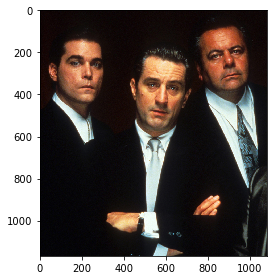

In [3]:
# input 
image = io.imread("dataset/1.jpg")
io.imshow(image)

In [4]:

WINDOW_SIZE = 18

trial = '5th' ### try alot 

if not os.path.exists(trial):
    os.mkdir(trial)

In [5]:
#helper functions

def to_integral(img):
    integral = np.cumsum(np.cumsum(img, axis=0), axis=1)
    return np.pad(integral, (1, 1), 'constant', constant_values=(0, 0))[:-1, :-1]



def gamma(values, coeff=2.2):
    return values**(1./coeff)


def read_face(path):
    
    CROP_TOP = 30
    img = rgb2gray(io.imread(path))
    img=img[CROP_TOP:]
    img=gamma(img)
    img = cv2.resize(img, (WINDOW_SIZE,WINDOW_SIZE))
    return img

def read_background(path):
      
    img = rgb2gray(io.imread(path))
    img=gamma(img)
    CROP_TOP = int(np.random.random()*img.shape[0])
    CROP_LEFT = int(np.random.random()*img.shape[1])
    img2=img[CROP_TOP:,CROP_LEFT:]
    img2 = cv2.resize(img2, (WINDOW_SIZE,WINDOW_SIZE))
    return img2


# Viola Jones Algorithm

In [6]:
class Feature:
    def __init__(self, x: int, y: int, width: int, height: int):
        self.x = x
        self.y = y
        self.width = width
        self.height = height

    def __call__(self, integral_image: np.ndarray):
            return np.sum(np.multiply(integral_image[self.coords_y, self.coords_x], self.coeffs))
        
    
    def __repr__(self):
        return f'{self.__class__.__name__}(x={self.x}, y={self.y}, width={self.width}, height={self.height})'



class Feature2h(Feature):
    def __init__(self, x: int, y: int, width: int, height: int):
        super().__init__(x, y, width, height)
        hw = width // 2
        self.coords_x = [x,  x + hw, x,  x + hw, x + hw, x + width,  x + hw,     x + width]
        self.coords_y = [y ,y ,  y + height, y + height, y,  y, y + height, y + height]
        self.coeffs   = [1,     -1,         -1,          1, -1,     1,          1,         -1]



class Feature2v(Feature):
    def __init__(self, x: int, y: int, width: int, height: int):
        super().__init__(x, y, width, height)
        hh = height // 2        
        self.coords_x = [x,      x + width,  x,          x + width,
                         x,      x + width,  x,          x + width]
        self.coords_y = [y,      y,          y + hh,     y + hh,
                         y + hh, y + hh,     y + height, y + height]
        self.coeffs   = [-1,     1,          1,         -1,
                         1,     -1,         -1,          1]



class Feature3h(Feature):
    def __init__(self, x: int, y: int, width: int, height: int):
        super().__init__(x, y, width, height)
        tw = width // 3
        self.coords_x = [x,        x + tw,    x,          x + tw,
                         x + tw,   x + 2*tw,  x + tw,     x + 2*tw,
                         x + 2*tw, x + width, x + 2*tw,   x + width]
        self.coords_y = [y,        y,         y + height, y + height,
                         y,        y,         y + height, y + height,
                         y,        y,         y + height, y + height]
        self.coeffs   = [-1,       1,         1,         -1,
                          1,      -1,        -1,          1,
                         -1,       1,         1,         -1]



class Feature3v(Feature):
    def __init__(self, x: int, y: int, width: int, height: int):
        super().__init__(x, y, width, height)
        th = height // 3
        self.coords_x = [x,        x + width,  x,          x + width,
                         x,        x + width,  x,          x + width,
                         x,        x + width,  x,          x + width]
        self.coords_y = [y,        y,          y + th,     y + th,
                         y + th,   y + th,     y + 2*th,   y + 2*th,
                         y + 2*th, y + 2*th,   y + height, y + height]
        self.coeffs   = [-1,        1,         1,         -1,
                          1,       -1,        -1,          1,
                         -1,        1,         1,         -1]



class Feature4(Feature):
    def __init__(self, x: int, y: int, width: int, height: int):
        super().__init__(x, y, width, height)
        hw = width // 2
        hh = height // 2
        self.coords_x = [x,      x + hw,     x,          x + hw,     # upper row
                         x + hw, x + width,  x + hw,     x + width,
                         x,      x + hw,     x,          x + hw,     # lower row
                         x + hw, x + width,  x + hw,     x + width]
        self.coords_y = [y,      y,          y + hh,     y + hh,     # upper row
                         y,      y,          y + hh,     y + hh,
                         y + hh, y + hh,     y + height, y + height, # lower row
                         y + hh, y + hh,     y + height, y + height]
        self.coeffs   = [1,     -1,         -1,          1,          # upper row
                         -1,     1,          1,         -1,
                         -1,     1,          1,         -1,          # lower row
                          1,    -1,         -1,          1]
    

In [7]:

def possible_position(size, window_size= WINDOW_SIZE):
    return range(0, window_size - size + 1)

def possible_locations(w,h, window_size = WINDOW_SIZE):
    return ((x, y)
            for x in possible_position(w, window_size) 
            for y in possible_position(h, window_size))

def possible_shapes(w,h, window_size= WINDOW_SIZE):
    base_height = h
    base_width = w
    return ((height, width)
          for width in range(base_width, window_size + 1, base_width)
          for height in range(base_height, window_size + 1, base_height))
    


feature2h = list(Feature2h(x, y, width, height)
                 for (height, width) in possible_shapes(h=1, w=2)
                 for (x, y) in possible_locations(h=height,w=width))

feature2v = list(Feature2v(x, y, width, height)
                 for (height, width) in possible_shapes(h=2, w=1)
                 for (x, y) in possible_locations(h=height,w=width))

feature3h = list(Feature3h(x, y, width, height)
                 for (height, width) in possible_shapes(h=1, w=3)
                 for (x, y) in possible_locations(h=height,w=width))


feature3v = list(Feature3h(x, y, width, height)
                 for (height, width) in possible_shapes(h=3, w=1)
                 for (x, y) in possible_locations(h=height,w=width))

feature4 = list(Feature4(x, y, width, height)
                 for (height, width) in possible_shapes(h=2, w=2)
                 for (x, y) in possible_locations(h=height,w=width))

 
features = feature2h + feature2v + feature3h + feature3v + feature4


print(f'Number of feature2h features: {len(feature2h)}')
print(f'Number of feature2v features: {len(feature2v)}')
print(f'Number of feature3h features: {len(feature3h)}')
print(f'Number of feature3v features: {len(feature3v)}')
print(f'Number of feature4 features:  {len(feature4)}')
print(f'Total number of features:     {len(features)}')

Number of feature2h features: 13851
Number of feature2v features: 13851
Number of feature3h features: 8721
Number of feature3v features: 8721
Number of feature4 features:  6561
Total number of features:     51705


In [8]:

class weakClassifier:
    def __init__(self, feature: Feature, threshold: float, polarity: int, alpha=None):
        self.feature=feature
        self.threshold=threshold
        self.polarity=polarity
        self.alpha=alpha 
   
    def run(self,i):
          if((self.polarity * self.feature(i)) < (self.polarity * self.threshold)):
            return 1.0
          else:
            return 0.0


class Classifier:
    def __init__(self,weakClassifiersList ):
        self.weakClassifiers=weakClassifiersList

    def isFace(self,ii,sum_hy=0.,sum_al=0.):
        sum_hypotheses = sum_hy
        sum_alphas = sum_al
        for c in self.weakClassifiers:
            sum_hypotheses += c.alpha * c.run(ii)
            sum_alphas += c.alpha
        prop=(sum_hypotheses) /(.5*sum_alphas)
        return prop ,sum_hypotheses,sum_alphas

In [9]:
@jit(nopython=True)
def build_running_sums(ys, ws) :
    s_minus, s_plus = 0., 0.
    t_minus, t_plus = 0., 0.
    s_minuses, s_pluses = [], []
    
    for y, w in zip(ys, ws):
        if y < .5:
            s_minus += w
            t_minus += w
        else:
            s_plus += w
            t_plus += w
        s_minuses.append(s_minus)
        s_pluses.append(s_plus)
    return t_minus, t_plus, s_minuses, s_pluses


@jit(nopython=True)
def find_best_threshold(zs, t_minus, t_plus, s_minuses, s_pluses):
    min_e = 1000000000.0
    min_z, polarity = 0, 0
    for z, s_m, s_p in zip(zs, s_minuses, s_pluses):
        error_1 = s_p + (t_minus - s_m)
        error_2 = s_m + (t_plus - s_p)
        if error_1 < min_e:
            min_e = error_1
            min_z = z
            polarity = -1
        elif error_2 < min_e:
            min_e = error_2
            min_z = z
            polarity = 1
    return min_z, polarity

@jit(nopython=True)
def determine_threshold_polarity(ys, ws, zsi,p):  
    # Sort according to score
    zs=np.copy(zsi)
   
    zs, ys, ws = zs[p], ys[p], ws[p]
    
    # Determine the best threshold: build running sums
    t_minus, t_plus, s_minuses, s_pluses = build_running_sums(ys, ws)
    
    # Determine the best threshold: select optimal threshold.
    return find_best_threshold(zs, t_minus, t_plus, s_minuses, s_pluses) 

In [10]:

def apply_feature(f, xis, ys, ws,zs,p):   
  
    
    # Determine the best threshold
    threshold,polarity = determine_threshold_polarity(ys, ws, zs,p)
            
    # Determine the classification error
    classification_error = 0.
    c = weakClassifier(f, threshold,polarity)
    for x, y, w in zip(xis, ys, ws):
        h=c.run(x)
        classification_error += w * np.abs(h - y)
    return classification_error,c

In [11]:
      
      
        #####################################################
        
        def getbest(prm):
          
            
            KEEP_PROBABILITY = 1./4.
         

            # Select best weak classifier for this round
            best_error=float('inf')
            best_classifier=None
            w=prm[1]
            for i in (prm[0]):
                improved = False

                # Python runs singlethreaded. To speed things up,
                # we're only anticipating every other feature, give or take.
                if KEEP_PROBABILITY < 1.:
                    skip_probability = np.random.random()
                    if skip_probability > KEEP_PROBABILITY:
                        continue

                e,c = apply_feature(features[i], xis, ys, w,zss[i],ps[i])
                if e < best_error:
                    improved = True
                    best_error =e 
                    best_classifier=c

                # Print status 
                if improved:
                    print(f'p={int(prm[0][0]/len(prm[0]))} {i%len(prm[0])}/{len(prm[0])} error improved to {best_error:.5f} using {str(best_classifier.feature)} ...')
                    
            return [best_classifier,best_error]
                        
                 ################################################       
                        
                        

In [12]:
def train_Classifier(prefix, num_features, xis, ys, features,zss,ps, ws = None) :
    if ws is None:
        m = len(ys[ys < .5])  # number of negative examples
        l = len(ys[ys > .5])  # number of positive examples

        # Initialize the weights
        ws = np.zeros_like(ys)
        ws[ys < .5] = 1./(2.*m)
        ws[ys > .5] = 1./(2.*l)



    STATUS_EVERY     = 4000
    KEEP_PROBABILITY = 1./4.
    
    # Keep track of the history of the example weights.
    w_history = ws


    total_start_time = datetime.now()
    weak_classifiers = [] 
    for t in range(num_features):
            print(f'Building weak classifier {t+1}/{num_features} ...')
            best_error=float('inf')
            best_classifier=None
            start_time = datetime.now()
            
            # Normalize the weights
            ws = ws / ws.sum()

            ##################################################### parallel
            numofproc=5
            prms=[]
            step_num_Feature=len(features)//numofproc
            for i in range(numofproc):
                prms.append([list(range(i*step_num_Feature,(i+1)*step_num_Feature)),ws])
            results=[]
            with concurrent.futures.ProcessPoolExecutor() as executor:
                results = executor.map(getbest, prms)
                
            print(f'Done  procs ...')
            for r in results:
                print(r)
                if(r[1]<best_error):
                    best_error=r[1]
                    best_classifier=r[0]
               
           
            
            print(f'best error : ',best_error)
            
            
            #####################################################
             
                        
            # After the best classifier was found, determine alpha
            beta = best_error / (1 - best_error)
            alpha = np.log(1. / beta)
            
            # Build the weak classifier
            best_classifier.alpha=alpha
            
            # Update the weights for misclassified examples
            for i, (x, y) in enumerate(zip(xis, ys)):
                h = best_classifier.run(x)
                e = np.abs(h - y)
                ws[i] = ws[i] * np.power(beta, 1-e)
                
            # Register this weak classifier           
            weak_classifiers.append(best_classifier)
            current_time = datetime.now()
            duration = current_time - start_time
            total= current_time-total_start_time
            print(f'Done Building weak classifier {t+1}/{num_features} duration:{duration.total_seconds()/60:.2f}m  Total:{total.total_seconds()/60:.2f}m ...',str(best_classifier.feature)," alpha : ",alpha)

    
    w_history=ws
    print(f'Done building {num_features} weak classifiers.')
    print(f' building {num_features} Features Strong classifier...')
    strong =Classifier(weak_classifiers)
    pickle.dump(strong, open(f'{trial}/{prefix}_learner_{num_features}_features.pkl', 'wb'))
    pickle.dump(w_history, open(f'{trial}/w_history_{prefix}.pkl', 'wb'))
    print(f'Done ')
    return strong, w_history

# Datasets Loading

In [ ]:
#You can find the datasets here 
#Face1 data : https://www.dropbox.com/s/ubjjoo0b2wz4vgz/faces_aligned_small_mirrored_co_aligned_cropped_cleaned.tar.gz?dl=1
#Face2 data : https://www.kaggle.com/gasgallo/faces-data-new
#BackGround1 : (iccv09) https://www.kaggle.com/balraj98/stanford-background-dataset
#BackGround2 : (BG-20K) https://drive.google.com/drive/folders/1ZBaMJxZtUNHIuGj8D8v3B9Adn8dbHwSS

dataset_path = 'dataset'

if not os.path.exists(dataset_path):
    os.mkdir(dataset_path)


faces_dir = os.path.join(dataset_path, 'faces1')
face_image_files = glob.glob(os.path.join(faces_dir, '**', '*.png'), recursive=True)
print("len(face_image_files) :"+str(len(face_image_files)))



face_image_files2=glob.glob(os.path.join('dataset/faces2', "*"))
print("len(face_image_files2) :"+str(len(face_image_files2)))




backgrounds_dir = os.path.join(dataset_path, 'iccv09Data')
background_image_files = glob.glob(os.path.join(backgrounds_dir, '**', '*.jpg'), recursive=True)
print("len(background_image_files) : "+str(len(background_image_files)))



backgrounds_dir2 = os.path.join(dataset_path, 'BG')
background_image_files2 = glob.glob(os.path.join(backgrounds_dir2, '**', '*.jpg'), recursive=True)
print("len(background_image_files2) : "+str(len(background_image_files2)))


In [218]:
%%time

def sample_data(p , n ) :
    xs = []
    xs.extend([(read_face(f)) for f in random.sample(face_image_files, p//2)])
    xs.extend([(read_face(f)) for f in random.sample(face_image_files2, p//2)])
    xs.extend([(read_background(f)) for f in random.sample(background_image_files, n//4)])
    xs.extend([(read_background(f)) for f in random.sample(background_image_files2, int(3*(n//4)))])

    ys = np.hstack([np.ones((p,)), np.zeros((n,))])
    arr=np.array(xs)
   
    return arr , ys



random.seed(456)
np.random.seed(456)
xs, ys = sample_data(2600, 2600)
xis = np.array([to_integral(x) for x in xs])
pickle.dump(xis, open(f'{trial}/xis.pkl', 'wb'))
pickle.dump(ys, open(f'{trial}/ys.pkl', 'wb'))



random.seed(20)
np.random.seed(20)
test_xs, test_ys = sample_data(2600, 2600)
test_xis = np.array([to_integral(x) for x in test_xs])
pickle.dump(test_xis, open(f'{trial}/test_xis.pkl', 'wb'))
pickle.dump(test_ys, open(f'{trial}/test_ys.pkl', 'wb'))
    


CPU times: user 4min 37s, sys: 15.7 s, total: 4min 53s
Wall time: 6min 12s


In [ ]:
%%time

def extractFeaturesFromImages(features,num,xis):
    zss=[]
    ps=[]
    features=random.sample(features,num)
    pickle.dump(features, open(f'{trial}/features.pkl', 'wb'))
    for f in features :
        zs=[]
        ysz=[]
        for x in xis:
            zs.append(f(x))
        p = np.argsort(zs)
        ps.append(p)
        zss.append(zs)

    zss=np.array(zss)
    ps=np.array(ps)
    pickle.dump(zss, open(f'{trial}/zss.pkl', 'wb'))
    pickle.dump(ps, open(f'{trial}/ps.pkl', 'wb'))
    return zss ,ps ,features



zss,ps,features=extractFeaturesFromImages(features,45000,xis)


In [14]:
print("xis ",xis.shape)
print("ys ",ys.shape)
print("test_xis ",test_xis.shape)
print("test_ys",test_ys.shape)

print("zss ",zss.shape)
print("ps ",ps.shape)
print("features ",len(features))


xis  (5200, 19, 19)
ys  (5200,)
test_xis  (5200, 19, 19)
test_ys (5200,)
zss  (45000, 5200)
ps  (45000, 5200)
features  45000


In [13]:
## load pervious data in case of trying again on same data 
features = pickle.load(open(f"{trial}/features.pkl",'rb'))

zss = pickle.load(open(f"{trial}/zss.pkl",'rb'))

ps = pickle.load(open(f"{trial}/ps.pkl",'rb'))

xis = pickle.load(open(f"{trial}/xis.pkl",'rb'))

ys = pickle.load(open(f"{trial}/ys.pkl",'rb'))

test_xis = pickle.load(open(f"{trial}/test_xis.pkl",'rb'))

test_ys = pickle.load(open(f"{trial}/test_ys.pkl",'rb'))


In [15]:
# load the model if it is trained before
model=pickle.load(open(f"{trial}/model.pkl",'rb'))


# Evaluation


<AxesSubplot:>

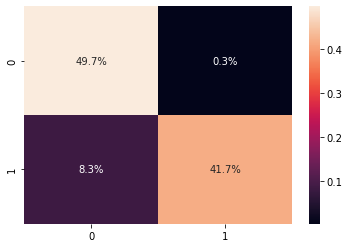

In [16]:
prediction_test=[]
for x in test_xis:
        isf=1
        s_h=0
        s_a=0
        for m in model:
            prop ,s_h, s_a=m.isFace(x,s_h,s_a)
            if (prop<1):
                isf=0
                break
        prediction_test.append(isf)
prediction_test=np.array(prediction_test)
cm = confusion_matrix(test_ys, prediction_test)
sns.heatmap(cm/cm.sum(), annot=True, fmt='.1%')



# Training 

#### Note : it takes alot of time 



Building weak classifier 1/20 ...
p=3 0/9000 error improved to 0.43210 using Feature2h(x=6, y=1, width=4, height=8) ...
p=0 0/9000 error improved to 0.45139 using Feature2v(x=6, y=14, width=9, height=2) ...
p=4 0/9000 error improved to 0.44968 using Feature2h(x=1, y=2, width=6, height=4) ...
p=2 0/9000 error improved to 0.45387 using Feature3h(x=17, y=0, width=1, height=18) ...
p=1 0/9000 error improved to 0.44856 using Feature4(x=0, y=9, width=8, height=2) ...
p=2 7/9000 error improved to 0.45240 using Feature2v(x=10, y=9, width=8, height=4) ...
p=2 8/9000 error improved to 0.44868 using Feature2v(x=6, y=13, width=9, height=2) ...
p=0 26/9000 error improved to 0.44333 using Feature2h(x=2, y=13, width=8, height=4) ...
p=3 44/9000 error improved to 0.42821 using Feature2v(x=4, y=13, width=14, height=4) ...
p=1 26/9000 error improved to 0.44249 using Feature3h(x=5, y=13, width=6, height=3) ...
p=2 65/9000 error improved to 0.43497 using Feature3h(x=0, y=1, width=12, height=2) ...
p=1 60/

p=1 6302/9000 error improved to 0.40881 using Feature3h(x=4, y=10, width=3, height=1) ...
p=3 7233/9000 error improved to 0.41012 using Feature2v(x=8, y=5, width=3, height=8) ...
Done  procs ...
[<__main__.weakClassifier object at 0x7f8e4c0692e0>, 0.407750816396165]
[<__main__.weakClassifier object at 0x7f8e4c133070>, 0.4088135214083364]
[<__main__.weakClassifier object at 0x7f8e4c133760>, 0.4137697609076802]
[<__main__.weakClassifier object at 0x7f8e4c0692b0>, 0.41011805871509216]
[<__main__.weakClassifier object at 0x7f8e4c133700>, 0.4087014935100326]
best error :  0.407750816396165
Done Building weak classifier 4/20 duration:4.61m  Total:36.12m ... Feature2v(x=8, y=6, width=2, height=8)  alpha :  0.37327122087554276
Building weak classifier 5/20 ...
p=4 0/9000 error improved to 0.43185 using Feature2h(x=1, y=2, width=6, height=4) ...
p=2 0/9000 error improved to 0.45590 using Feature3h(x=17, y=0, width=1, height=18) ...
p=1 0/9000 error improved to 0.45820 using Feature4(x=0, y=9, w

p=0 0/9000 error improved to 0.44075 using Feature2v(x=6, y=14, width=9, height=2) ...
p=2 0/9000 error improved to 0.45992 using Feature3h(x=17, y=0, width=1, height=18) ...p=3 0/9000 error improved to 0.43771 using Feature2h(x=6, y=1, width=4, height=8) ...

p=4 0/9000 error improved to 0.44228 using Feature2h(x=1, y=2, width=6, height=4) ...
p=1 0/9000 error improved to 0.46280 using Feature4(x=0, y=9, width=8, height=2) ...
p=2 7/9000 error improved to 0.44725 using Feature2v(x=10, y=9, width=8, height=4) ...
p=1 6/9000 error improved to 0.45870 using Feature2v(x=6, y=13, width=11, height=2) ...
p=0 8/9000 error improved to 0.43341 using Feature2h(x=6, y=13, width=8, height=5) ...
p=4 7/9000 error improved to 0.44143 using Feature2h(x=11, y=3, width=4, height=8) ...
p=1 7/9000 error improved to 0.43162 using Feature2h(x=13, y=8, width=4, height=10) ...
p=2 8/9000 error improved to 0.44608 using Feature2v(x=6, y=13, width=9, height=2) ...
p=0 26/9000 error improved to 0.42384 using 

p=0 0/9000 error improved to 0.44039 using Feature2v(x=6, y=14, width=9, height=2) ...
p=4 0/9000 error improved to 0.41798 using Feature2h(x=1, y=2, width=6, height=4) ...
p=2 0/9000 error improved to 0.43859 using Feature3h(x=17, y=0, width=1, height=18) ...
p=0 7/9000 error improved to 0.43810 using Feature2v(x=2, y=1, width=3, height=12) ...
p=1 0/9000 error improved to 0.44039 using Feature4(x=0, y=9, width=8, height=2) ...p=3 0/9000 error improved to 0.42511 using Feature2h(x=6, y=1, width=4, height=8) ...

p=0 8/9000 error improved to 0.41782 using Feature2h(x=6, y=13, width=8, height=5) ...
p=3 6/9000 error improved to 0.42479 using Feature2v(x=15, y=8, width=2, height=6) ...
p=2 7/9000 error improved to 0.43183 using Feature2v(x=10, y=9, width=8, height=4) ...
p=1 7/9000 error improved to 0.41797 using Feature2h(x=13, y=8, width=4, height=10) ...
p=3 29/9000 error improved to 0.41978 using Feature2h(x=13, y=7, width=4, height=7) ...
p=2 59/9000 error improved to 0.42628 using 

p=1 936/9000 error improved to 0.42555 using Feature2v(x=0, y=5, width=1, height=10) ...
p=2 1285/9000 error improved to 0.42858 using Feature3h(x=1, y=2, width=7, height=15) ...
p=4 957/9000 error improved to 0.42220 using Feature2v(x=2, y=0, width=1, height=4) ...
p=0 1468/9000 error improved to 0.42038 using Feature3h(x=1, y=6, width=9, height=2) ...
p=0 1692/9000 error improved to 0.41240 using Feature4(x=0, y=2, width=2, height=4) ...
p=2 1744/9000 error improved to 0.42185 using Feature3h(x=2, y=5, width=1, height=9) ...
p=1 2444/9000 error improved to 0.41604 using Feature3h(x=3, y=1, width=3, height=7) ...
p=2 3651/9000 error improved to 0.42161 using Feature2v(x=5, y=9, width=1, height=6) ...
p=3 3551/9000 error improved to 0.42080 using Feature3h(x=2, y=6, width=3, height=3) ...
p=4 4094/9000 error improved to 0.42033 using Feature3h(x=6, y=2, width=5, height=12) ...
p=3 4162/9000 error improved to 0.42070 using Feature2v(x=17, y=3, width=1, height=6) ...
p=1 5482/9000 error 

p=2 1319/9000 error improved to 0.41766 using Feature2h(x=3, y=9, width=6, height=1) ...
p=3 1335/9000 error improved to 0.41030 using Feature2h(x=3, y=17, width=4, height=1) ...
p=0 1629/9000 error improved to 0.40451 using Feature3h(x=2, y=15, width=12, height=3) ...
p=2 3661/9000 error improved to 0.41685 using Feature4(x=3, y=0, width=10, height=6) ...
p=2 3662/9000 error improved to 0.41680 using Feature2v(x=10, y=2, width=4, height=4) ...
p=2 4332/9000 error improved to 0.41662 using Feature3h(x=5, y=9, width=7, height=3) ...
p=2 4556/9000 error improved to 0.41528 using Feature3h(x=0, y=8, width=3, height=6) ...
p=2 6302/9000 error improved to 0.41064 using Feature3h(x=1, y=17, width=15, height=1) ...
p=3 5173/9000 error improved to 0.40968 using Feature2h(x=9, y=14, width=6, height=2) ...
p=3 6013/9000 error improved to 0.40441 using Feature2v(x=6, y=2, width=8, height=4) ...
p=4 7270/9000 error improved to 0.40981 using Feature3h(x=4, y=15, width=9, height=3) ...
Done  procs .

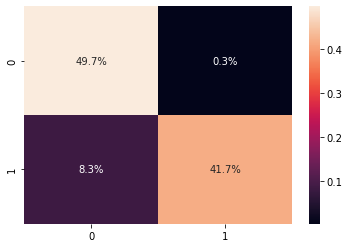

In [118]:
%%time

layers=[5 ,10,10,20,20,40,50,20] ## num of features
ws=None
for i in range(len(layers)):
    s, ws = train_Classifier(i, layers[i] , xis, ys, features,zss,ps,ws)

    model.append(s)
    prediction_test=[]
    for x in test_xis:
        isf=1
        s_h=0
        s_a=0
        for m in model:
            prop ,s_h, s_a=m.isFace(x,s_h,s_a)
            if (prop<1):
                isf=0
                break
        prediction_test.append(isf)
    prediction_test=np.array(prediction_test)
    cm = confusion_matrix(test_ys, prediction_test)

    
    print("Done building layer ",i ,"-------------------",cm/cm.sum())
    
sns.heatmap(cm/cm.sum(), annot=True, fmt='.1%')
pickle.dump(model, open(f'{trial}/model.pkl', 'wb'))
    

# Test on images and using Camera 


In [17]:
def showfaces(img,faces):
    im=np.copy(img)
    for row, col,w in faces:
        x=col*w
        y=row*w
        l=WINDOW_SIZE*w
        s=w
        cv2.rectangle(im, (x,y),(x+l,y+l), (255,0,0),3*(w//8))
        print(x,y,l)
    io.imshow(im)

700 40 360
40 120 360
374 198 396
CPU times: user 451 ms, sys: 10.8 ms, total: 462 ms
Wall time: 416 ms


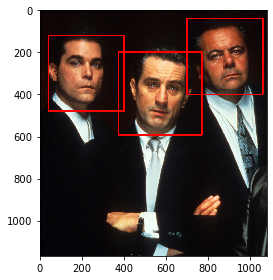

In [26]:
%%time
original_image = io.imread("dataset/1.jpg")
gray_image=rgb2gray(original_image)
    
def detect(img,model):
    
    wt=min(img.shape)//700+1
    img=cv2.resize(img,(img.shape[1]//wt,img.shape[0]//wt))
    gray=gamma(img)
    faces=[]
    Half_Window=WINDOW_SIZE//2
    for w in range(8,12,1):
        
        step=Half_Window//w+1
        sizex=gray.shape[1]//w
        sizey=gray.shape[0]//w

        target_size = (sizex, sizey)
        sizeim=cv2.resize(np.copy(gray),target_size)
        integral = to_integral(sizeim)

        rows, cols = integral.shape

        
        for row in range(0, rows - WINDOW_SIZE-2*step,3*step):
            for col in range(0, cols - WINDOW_SIZE-2*step,3*step):
                
                fr=0
                fc=0
                numf=0
                rs=[row ,row+step ,row+2*step,row ,row+step ,row+2*step,row ,row+step ,row+2*step]
                cs=[col,col,col,col+step,col+step,col+step,col+2*step,col+2*step,col+2*step]
                for i in range(9):
                    window = integral[rs[i]:rs[i]+WINDOW_SIZE+1, cs[i]:cs[i]+WINDOW_SIZE+1]
                    isf=1
                    s_h=0
                    s_a=0
                 
                    for m in model:
                        prop ,s_h, s_a=m.isFace(window,s_h,s_a)
                        if (prop<1.22):
                            isf=0
                            break
                        
                    if(isf==1):
                        numf+=1 
                        fr+=rs[i]
                        fc+=cs[i]
                        
                        
                if(numf>0):
                    fx=fr//numf
                    fy=fc//numf
                    overlabed=0
                    if (len(faces)>=3):
                        r=3
                    else:
                        r=len(faces)
                        
                    for s in range(0,r):
                        if(abs(faces[-s][0]*faces[-s][2]-fx*w*wt)+abs(faces[-s][1]*faces[-s][2]-fy*w*wt)<=9*wt*w):
                            faces[-s][0]=(faces[-s][0]*faces[-s][2]+fx*wt*w)//2+9
                            faces[-s][1]=(faces[-s][1]*faces[-s][2]+fy*wt*w)//2+9
                            faces[-s][2]=(faces[-s][2]+w*wt)//2-1
                            faces[-s][0]= faces[-s][0]//faces[-s][2]+1
                            faces[-s][1]=faces[-s][1]//faces[-s][2]+1
                            overlabed=1
                            break
                       
                    if(not overlabed):
                        faces.append([fx,fy,w*wt])
   
    return faces
            
faces=detect(gray_image,model)       
showfaces(original_image,faces)


In [27]:
# Try Your self 


cap = cv2.VideoCapture(0)
faces=[]
d=2

while True:
    # grab the frame from the video stream
    ret, frame = cap.read()
    wid= (frame.shape[1]-frame.shape[0])//2
    img =cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    d=d-1
 
    if(d<0):
        faces=detect(img, model)
        d=10
        
    for (x ,y , w ) in faces:
        rectColor=(255,0,0)
        stroke=2
        row=x*w
        col=y*w
        l=w*WINDOW_SIZE

        cv2.rectangle(frame, (col,row), (col+l,row+l), rectColor,stroke)
        
 
    cv2.imshow("Frame", frame)
    if cv2.waitKey(20) &  0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

QObject::moveToThread: Current thread (0x55cbc5edd690) is not the object's thread (0x55cbcac59e10).
Cannot move to target thread (0x55cbc5edd690)

QObject::moveToThread: Current thread (0x55cbc5edd690) is not the object's thread (0x55cbcac59e10).
Cannot move to target thread (0x55cbc5edd690)

QObject::moveToThread: Current thread (0x55cbc5edd690) is not the object's thread (0x55cbcac59e10).
Cannot move to target thread (0x55cbc5edd690)

QObject::moveToThread: Current thread (0x55cbc5edd690) is not the object's thread (0x55cbcac59e10).
Cannot move to target thread (0x55cbc5edd690)

QObject::moveToThread: Current thread (0x55cbc5edd690) is not the object's thread (0x55cbcac59e10).
Cannot move to target thread (0x55cbc5edd690)

QObject::moveToThread: Current thread (0x55cbc5edd690) is not the object's thread (0x55cbcac59e10).
Cannot move to target thread (0x55cbc5edd690)

QObject::moveToThread: Current thread (0x55cbc5edd690) is not the object's thread (0x55cbcac59e10).
Cannot move to tar